In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import os
from copy import copy
import multiprocess
import warnings
warnings.filterwarnings("ignore")

In [2]:
root = '/Users/adriancasaisvidal/storage/muonid/mep_tuples/'
root_mit = '/data/submit/lhcb/muonid/mep_tuples'
def rename(df):
    rename_dict={}
    for key in df.keys():
        if 'Hlt1' in key:
            rename_dict[key] = key.replace('Hlt1DiMuonHighMass__dev_','')[:-2]
    df.rename(columns=rename_dict,inplace=True)
    return df
def get_dfs(file):
    if 'is_muon_c9f9b70d;1' in ur.open(file).keys() and 'Hlt1DiMuonHighMass;1' in ur.open(file).keys():
        df_tracks = ur.open(f'{file}:is_muon_c9f9b70d/monitor_tree').arrays(library='pd').reset_index()
        df_jpsi = ur.open(f'{file}:Hlt1DiMuonHighMass/monitor_tree').arrays(library='pd').reset_index()
    else:
        df_jpsi = pd.DataFrame()
        df_tracks= pd.DataFrame()
    #df_tracks.query('ismuon==True')
    return rename(df_jpsi),df_tracks


In [3]:
mytuples = os.listdir(root)
#tuples = filter(lambda x: '268259' in x,tuples)
mytuples = list(map (lambda x: os.path.join(root,x),mytuples))
#print(mytuples)
#df_jpsi = rename(df_jpsi)

In [4]:
def addTrackInfo(df_cand,df_tracks):
    if df_cand.shape[0]==0:
        return pd.DataFrame()
    indices_p = -1*np.ones(len(df_cand))
    indices_m = -1*np.ones(len(df_cand))
    closevars = [
                #'qop',
                 'tx','ty']
    closevars_p = list(map(lambda x: 'muonp_'+ x,closevars))
    closevars_m = list(map(lambda x: 'muonm_'+ x,closevars))
    closevars_t = [#'qop',
                   'tx_velo','ty_velo']
    for i_r in range(df_cand.shape[0]):
        r_cand = df_cand.iloc[i_r]

        close = np.isclose(r_cand[closevars_p].to_numpy(),df_tracks[closevars_t].to_numpy(),rtol=0.005)
        close_qop = np.isclose(np.array(r_cand['muonp_qop']),df_tracks['qop'].to_numpy(),rtol=0.02)
        
        index_p = np.asarray(np.sum(close,axis=1)==len(closevars)).nonzero()
        index_qop_p = np.asarray(close_qop==True).nonzero()
        index_p = np.intersect1d(index_p,index_qop_p)
        
        if len(index_p):
            
            indices_p[i_r] = index_p[0]

            

        close = np.isclose(r_cand[closevars_m].to_numpy(),df_tracks[closevars_t].to_numpy(),rtol=0.005)
        close_qop = np.isclose(r_cand['muonm_qop'],df_tracks['qop'].to_numpy(),rtol=0.02)
        index_m = np.asarray(np.sum(close,axis=1)==len(closevars)).nonzero()
        index_qop_m = np.asarray(close_qop==True).nonzero()
        index_m = np.intersect1d(index_m,index_qop_m)
        if len(index_m):
            indices_m[i_r] = index_m[0]





    df_cand['index_p'] = indices_p
    df_cand['index_m'] = indices_m
    df_cand.query('index_p>0 and index_m>0',inplace=True)
    
    for c in 'p','m':
        cand_vars = [
                    f'muon{c}_t0',f'muon{c}_dt0',
                    f'muon{c}_t1',f'muon{c}_dt1',
                    f'muon{c}_z0',f'muon{c}_z1',f'muon{c}_z2',f'muon{c}_z3',
                    f'muon{c}_x0',f'muon{c}_x1',f'muon{c}_x2',f'muon{c}_x3',
                    f'muon{c}_y0',f'muon{c}_y1',f'muon{c}_y2',f'muon{c}_y3',
                    f'muon{c}_dx0',f'muon{c}_dx1',f'muon{c}_dx2',f'muon{c}_dx3',
                    f'muon{c}_dy0',f'muon{c}_dy1',f'muon{c}_dy2',f'muon{c}_dy3',
                     
                    f'muon{c}_tx_muon', f'muon{c}_ty_muon',
                    f'muon{c}_chi2x', f'muon{c}_chi2y',
                    f'muon{c}_tx_scifi',f'muon{c}_ty_scifi',
                    f'muon{c}_ax_scifi',f'muon{c}_ay_scifi',
                    f'muon{c}_tx_refit',f'muon{c}_ty_refit',
                    f'muon{c}_extrapol_dist',
                    f'muon{c}_occ2',f'muon{c}_occ3',f'muon{c}_occ4',f'muon{c}_occ5'
                    ]
                     
        track_vars = ['t0','dt0','t1','dt1',
                      'z0','z1','z2','z3',
                      'x0','x1','x2','x3',
                      'y0','y1','y2','y3',
                      'dx0','dx1','dx2','dx3',
                      'dy0','dy1','dy2','dy3',
                      'tx_muon','ty_muon',
                      'chi2x','chi2y',
                      'tx_scifi','ty_scifi',
                      'ax_scifi','ay_scifi',
                      'tx_refit','ty_refit','extrapol_dist',
                      'occ2','occ3','occ4','occ5']
        df_cand[cand_vars] = df_tracks.loc[df_cand[f'index_{c}'],track_vars].to_numpy()
        
        
    return df_cand.dropna()


In [5]:
def get_cands(tuples):
    out_df = addTrackInfo(*get_dfs(tuples[0]))
    n_iters = len(tuples)-1
    for i_tuple in range(n_iters):
        if not i_tuple % 5:
            print(f'Progress: {100.*i_tuple/n_iters:.2f} %',end='\r')
        out_df = pd.concat([out_df,addTrackInfo(*get_dfs(tuples[i_tuple]))])
    return out_df
def fill_in_parallel(n_chunks,tuples):
    chunk_size = int(np.ceil(len(tuples)/n_chunks))
    #print(chunk_size)
    inputs = []
    for i in range(n_chunks):
        first = int(i*chunk_size)
        last = (i+1)*chunk_size
        if last > len(tuples):
            last = -1
        chunk = tuples[first:last]
        inputs.append(chunk)
    #print(inputs)
    pool = multiprocess.Pool(processes=n_chunks)
    outputs = pool.map(get_cands, inputs)    
    out_df = outputs[0]
    for i in range(len(outputs)-1):
        out_df = pd.concat([out_df,outputs[i]])
    return out_df
df_cands = fill_in_parallel(5,mytuples)

In [6]:
def chi2_corr(df,prefix=''):
    def covij(i,j,p):
            if i>j:
                i,j=j,i
            val = 0
            higher = j+1
            if p< 6000:
                higher = min(j+1,4)
            for l in range(higher):
                val += (z_m[i]-absorb[l][0])*(z_m[j]-absorb[l][0])*13.6**2*absorb[l][1]
            return val/p**2
    absorb = [[12800,25],   #ECAL
              [14300,53],   #HCAL
              [15800,47.5], #M2
              [17100,47.5], #M3
              [18300,47.5]] #M4
    
    for i in range(4):
        df.eval(f'{prefix}xs{i}= {prefix}tx_scifi*{prefix}z{i} + {prefix}ax_scifi',inplace=True)
        df.eval(f'{prefix}ys{i}= {prefix}ty_scifi*{prefix}z{i} + {prefix}ay_scifi',inplace=True)
    #df[f'{prefix}chi2corr']=0
    chi2corr_a=[]
    chi2uncorr_a = []
    no_hits = []
    for _,r in df.iterrows():
        x_m = np.array([r[f'{prefix}x0'],r[f'{prefix}x1'],r[f'{prefix}x2'],r[f'{prefix}x3']])
        y_m = np.array([r[f'{prefix}y0'],r[f'{prefix}y1'],r[f'{prefix}y2'],r[f'{prefix}y3']])
        z_m = np.array([r[f'{prefix}z0'],r[f'{prefix}z1'],r[f'{prefix}z2'],r[f'{prefix}z3']])
        
        padx = 2*np.array([r[f'{prefix}dx0'],r[f'{prefix}dx1'],r[f'{prefix}dx2'],r[f'{prefix}dx3']])
        pady = 2*np.array([r[f'{prefix}dy0'],r[f'{prefix}dy1'],r[f'{prefix}dy2'],r[f'{prefix}dy3']])
        
        x_s = np.array([r[f'{prefix}xs0'],r[f'{prefix}xs1'],r[f'{prefix}xs2'],r[f'{prefix}xs3']])
        y_s = np.array([r[f'{prefix}ys0'],r[f'{prefix}ys1'],r[f'{prefix}ys2'],r[f'{prefix}ys3']])
        mask = x_m != -99999

        no_hits.append(np.sum(mask))
        x_m = x_m[mask]
        y_m = y_m[mask]
        padx = padx[mask]
        pady = pady[mask]
                           
        x_s = x_s[mask]
        y_s = y_s[mask]
        
        dx = x_m - x_s
        dy = y_m - y_s
        
        s = len(x_m)
        cov = np.zeros((s,s))
        # for i_station in range(4):
        #     for j_station in range(i_station+1):
        #         if i_station == j_station:
        #             continue
        #         cov[i_station,j_station]= list(
        #             accumulate(absorb[0:j_station+2],initial=0,
        #             func=lambda init,c: 
        #                 init+(z_m[i_station]-c[0])*(z_m[j_station]-c[0])*13.6**2*c[1]))[-1]/(r['p'])**2
        #         cov[j_station,i_station]=cov[i_station,j_station]
        
        
        
        
            
        for i_station in range(s):
            for j_station in range(i_station+1):
                    cov[i_station,j_station]=covij(i_station,j_station,np.abs(r[f'{prefix}p']))
                    cov[j_station,i_station]=covij(i_station,j_station,np.abs(r[f'{prefix}p']))
                
        covx = cov
        covy = copy(covx)
        
        covxuncorr = np.zeros((s,s))
        covyuncorr = np.zeros((s,s))
        for i in range(s):
                covx[i,i] += (padx[i]/np.sqrt(12))**2
                covxuncorr[i,i] += (padx[i]/np.sqrt(12))**2
                covy[i,i] += (pady[i]/np.sqrt(12))**2
                covyuncorr[i,i] += (pady[i]/np.sqrt(12))**2
            
        
        resx = np.all(np.linalg.eigvals(covx) > 0)
        resy = np.all(np.linalg.eigvals(covy) > 0)
        
        if not (resx and resy):
            #print(f'Matrix x is {resx} PD. Matrix y is {resy} PD')
            pass
        chi2uncorr = (dx @ np.linalg.inv(covxuncorr) @ dx + dy @ np.linalg.inv(covyuncorr) @ dy)/s
        

        
        chi2corrx  = dx @ np.linalg.inv(covx) @ dx
        chi2corry = dy @ np.linalg.inv(covy) @ dy
        chi2corr = (chi2corrx + chi2corry)/s
            
        
            
        
        
        
        chi2corr_a.append(chi2corr)
        chi2uncorr_a.append(chi2uncorr)
        # print(dx)
        # print(chi2corr)
        # print(x_m)
        
    df[f'{prefix}chi2corr']=np.log10(np.abs(chi2corr_a))
    df[f'{prefix}chi2uncorr']=np.log10(np.abs(chi2uncorr_a))
    df[f'{prefix}no_hits'] = no_hits
    return df

In [7]:
def create_branches(c,df):
    df.eval(f'muon{c}_p=abs(muon{c}_qop)',inplace=True)
    df.eval(f'muon{c}_pt=sqrt((muon{c}_tx**2+muon{c}_ty**2)/(1+muon{c}_tx**2+muon{c}_ty**2))*muon{c}_p',inplace=True)
    df.eval(f'muon{c}_dtx=abs(muon{c}_tx_scifi-muon{c}_tx_muon)',inplace=True)
    df.eval(f'muon{c}_dty=abs(muon{c}_ty_scifi-muon{c}_ty_muon)',inplace=True)
    
    df.eval(f'muon{c}_dtx_refit=abs(muon{c}_tx_scifi-muon{c}_tx_refit)',inplace=True)
    df.eval(f'muon{c}_dty_refit=abs(muon{c}_ty_scifi-muon{c}_ty_refit)',inplace=True)
    
    df.fillna(0)
    
    return df

def applyBDTMuon(df,c,features,bdts):
    new_features = list(map(lambda x: f'muon{c}_'+x,features))
    mydict={}
    for i in range(len(features)):
        mydict[new_features[i]]=features[i]  
    X = copy(df[new_features])
    X.rename(columns=mydict,inplace=True)
    val = np.zeros(X.shape[0])
    for bdt in bdts:
        val += bdt.predict_proba(X)[:,1]/len(bdts)
    df[f'muon{c}_bdt']=val
    return df

df_cands_copy = copy(df_cands)
print(df_cands.keys())
df_cands = create_branches('p',df_cands)
df_cands = create_branches('m',df_cands)
df_cands = chi2_corr(df_cands,'muonp_')
df_cands = chi2_corr(df_cands,'muonm_')

Index(['index', 'm', 'muonp_tx', 'muonp_ty', 'muonp_qop', 'muonm_tx',
       'muonm_ty', 'muonm_qop', 'ev', 'index_p', 'index_m', 'muonp_t0',
       'muonp_dt0', 'muonp_t1', 'muonp_dt1', 'muonp_z0', 'muonp_z1',
       'muonp_z2', 'muonp_z3', 'muonp_x0', 'muonp_x1', 'muonp_x2', 'muonp_x3',
       'muonp_y0', 'muonp_y1', 'muonp_y2', 'muonp_y3', 'muonp_dx0',
       'muonp_dx1', 'muonp_dx2', 'muonp_dx3', 'muonp_dy0', 'muonp_dy1',
       'muonp_dy2', 'muonp_dy3', 'muonp_tx_muon', 'muonp_ty_muon',
       'muonp_chi2x', 'muonp_chi2y', 'muonp_tx_scifi', 'muonp_ty_scifi',
       'muonp_ax_scifi', 'muonp_ay_scifi', 'muonp_tx_refit', 'muonp_ty_refit',
       'muonp_extrapol_dist', 'muonp_occ2', 'muonp_occ3', 'muonp_occ4',
       'muonp_occ5', 'muonm_t0', 'muonm_dt0', 'muonm_t1', 'muonm_dt1',
       'muonm_z0', 'muonm_z1', 'muonm_z2', 'muonm_z3', 'muonm_x0', 'muonm_x1',
       'muonm_x2', 'muonm_x3', 'muonm_y0', 'muonm_y1', 'muonm_y2', 'muonm_y3',
       'muonm_dx0', 'muonm_dx1', 'muonm_dx2', 'muo

BDT retention: 1.55%


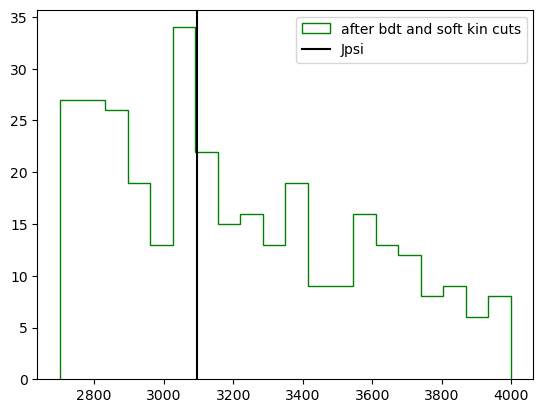

In [8]:
def myhist(data,bins):
    y,binEdges = np.histogram(data,bins=bins)
    bincenters = (binEdges[1:]+binEdges[:-1])/2
    binwidth = np.abs(binEdges[1:]-binEdges[:-1])/2
    menStd     = np.sqrt(y)
    plt.errorbar(bincenters, y, xerr=binwidth, color='r', yerr=menStd,drawstyle='steps-mid',ecolor='black')
    #plt.show()
import pickle
with open('muon_bdt.pkl','rb') as handle:
    features,bdts = pickle.load(handle)
    
df_cands = applyBDTMuon(df_cands,'p',features,bdts)
df_cands = applyBDTMuon(df_cands,'m',features,bdts)

mass_cut = '(m>2700 and m < 4000 and muonm_pt>.3e3 and muonp_pt > .3e3 and muonm_p>6e3 and muonp_p>6e3)'

cut_bdt= 0.75

cut = f'muonp_bdt > {cut_bdt} and muonm_bdt > {cut_bdt} and {mass_cut}'

print(f'BDT retention: {100.*df_cands.query(cut).shape[0]/df_cands.query(mass_cut).shape[0]:.2f}%')
output = True
df_bdt = df_cands.query(cut)
if output:
    df_bdt.to_hdf('jpsi_data.h5','jpsi')
nbins = 20
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# plt.axes().xaxis.set_major_locator(MultipleLocator(200))
# plt.axes().xaxis.set_minor_locator(MultipleLocator(50))xt

#plt.hist(df_cands.query(mass_cut)['m'],bins=nbins,histtype='step',density=1,label='uncut data')
plt.hist(df_bdt['m'],bins=nbins,density=0,label='after bdt and soft kin cuts',color='green',alpha=1,histtype='step')
#myhist(df_bdt['m'],bins=nbins)
plt.axvline(x = 3096.9, color = 'black',label='Jpsi')
#plt.axvline(x = 3686.10, color = 'red',label='psi(2s)')

# plt.savefig('data_spectrum.png')
plt.legend()
plt.show()

# for i in [0,0.2,0.9]:
#     cut_bdt = i
#     cut = f'muonp_bdt > {cut_bdt} and mu|onm_bdt > {cut_bdt} and {mass_cut}'
#     plt.hist(df_cands.query(cut)['m'],bins=nbins,histtype='step',density=1,label=f'cut={cut_bdt:.2f}',alpha=1)
# plt.legend()
# plt.show()

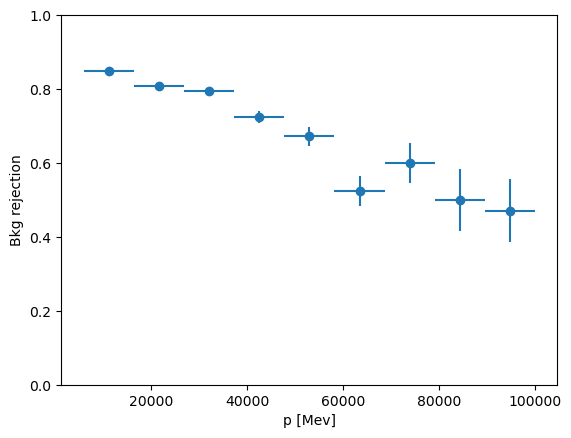

In [9]:
p_bins = np.linspace(6000,100000,10)
xcenters = (p_bins[:-1] + p_bins[1:]) / 2
width= (p_bins[1:] - p_bins[:-1])/2
rejs = []
errors = []
for i in range(len(p_bins)-1):
    low = p_bins[i]
    high = p_bins[i+1]
    p_cut = f'muonp_p > {low} and muonp_p < {high}'
    num = df_cands.query(f'muonp_bdt > 0.5 and {p_cut}').shape[0]
    den = df_cands.query(p_cut).shape[0]
    rej = (1-num/den)
    errors.append(np.sqrt(num*(den-num)/den**3))
    rejs.append(rej)
plt.ylim([0,1])
plt.xlabel('p [Mev]')
plt.ylabel('Bkg rejection')
plt.errorbar(xcenters,rejs,yerr = errors,xerr=width,marker='o',linestyle='None')
plt.show()

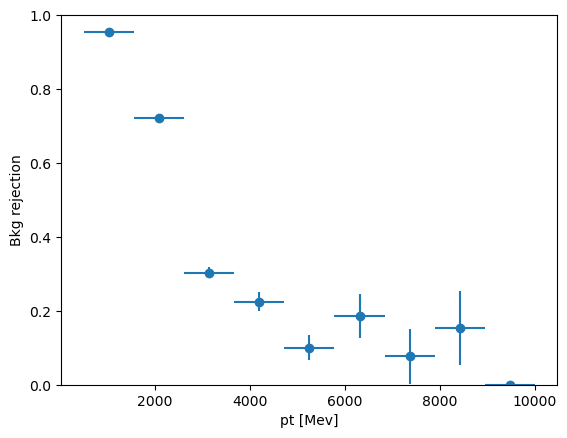

In [10]:
pt_bins = np.linspace(500,10000,10)
xcenters = (pt_bins[:-1] + pt_bins[1:]) / 2
width= (pt_bins[1:] - pt_bins[:-1])/2
rejs = []
errors = []
for i in range(len(pt_bins)-1):
    low = pt_bins[i]
    high = pt_bins[i+1]
    p_cut = f'muonm_pt > {low} and muonm_pt < {high}'
    num = df_cands.query(f'muonm_bdt > 0.5 and {p_cut}').shape[0]
    den = df_cands.query(p_cut).shape[0]
    rej = (1-num/den)
    errors.append(np.sqrt(num*(den-num)/den**3))
    rejs.append(rej)
plt.ylim([0,1])
plt.xlabel('pt [Mev]')
plt.ylabel('Bkg rejection')
plt.errorbar(xcenters,rejs,yerr = errors,xerr=width,marker='o',linestyle='None')
plt.show()

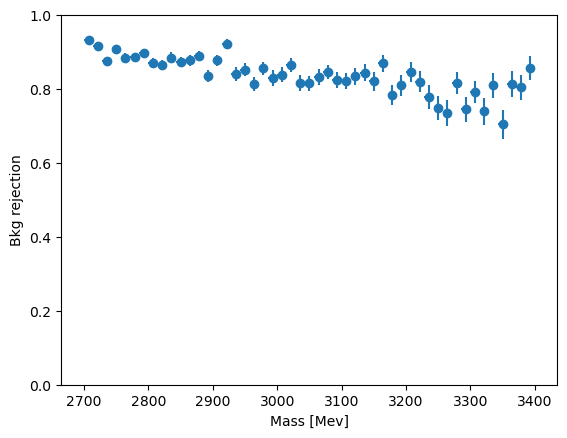

In [11]:
m_bins = np.linspace(2700,3400,50)
xcenters = (m_bins[:-1] + m_bins[1:]) / 2
width= (m_bins[1:] - m_bins[:-1])/2
rejs = []
errors = []
for i in range(len(m_bins)-1):
    low = m_bins[i]
    high = m_bins[i+1]
    p_cut = f'm > {low} and m < {high}'
    num = df_cands.query(f'muonp_bdt > 0.5 and {p_cut}').shape[0]
    den = df_cands.query(p_cut).shape[0]
    rej = (1-num/den)
    errors.append(np.sqrt(num*(den-num)/den**3))
    rejs.append(rej)
plt.ylim([0,1])
plt.xlabel('Mass [Mev]')
plt.ylabel('Bkg rejection')
plt.errorbar(xcenters,rejs,yerr = errors,xerr=width,marker='o',linestyle='None')
plt.show()

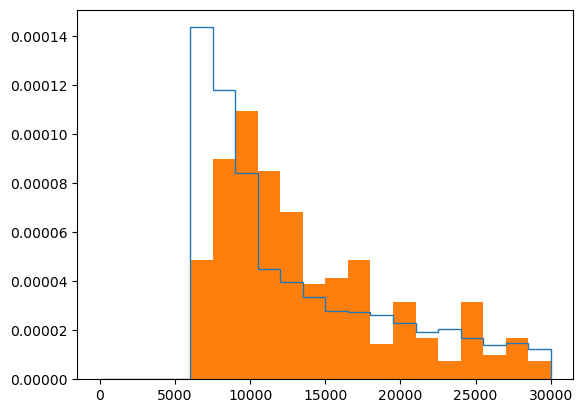

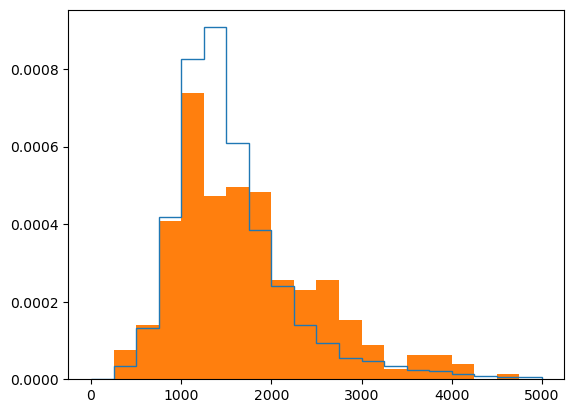

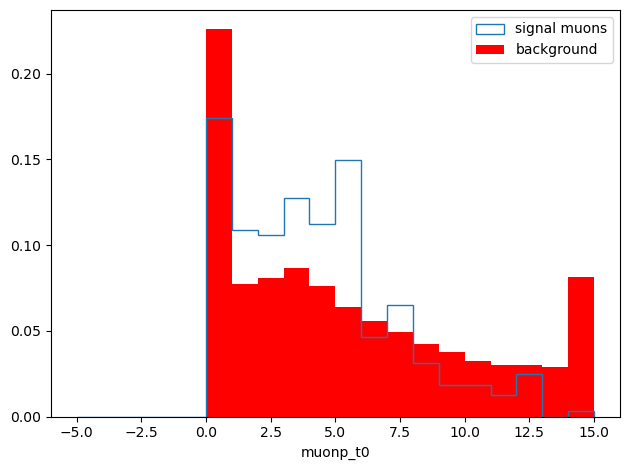

In [ ]:
nbins=20

# plt.hist(df_cands['muonp_bdt'],bins=nbins,histtype='step',density=True)
# plt.hist(df_cands['muonp_bdt'],bins=nbins,density=True)
# plt.show()
plt.hist(df_cands['muonp_p'],bins=nbins,histtype='step',range=(0,30e3),density=True)
plt.hist(df_bdt['muonp_p'],bins=nbins,range=(0,30e3),density=True)
plt.show()

plt.hist(df_cands['muonp_pt'],bins=nbins,histtype='step',range=(0,5e3),density=True)
plt.hist(df_bdt['muonp_pt'],bins=nbins,range=(0,5e3),density=True)
plt.show()
def compare_plot(df_s,df_b,var,w=None,discrete=False):
    if w == None or type(w)==tuple:
        myrange = w
    else:
        myrange = (-w,w)
    nbins=50
    if discrete:
        nbins=myrange[1]-myrange[0]
    plt.hist(df_s[var],bins=nbins,density=True,range=myrange,histtype='step',label='signal muons')
    plt.hist(df_b[var],bins=nbins,density=True,range=myrange,label='background',color='red')
    plt.xlabel(var)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'distributions/{var}.png')
    plt.show()

compare_plot(df_bdt,df_cands,'muonp_t0',w=(-5,15),discrete=True)
compare_plot(df_bdt,df_cands,'muonp_dt0',w=(-5,15),discrete=True)



# plt.hist(df_cands['muonp_chi2corr'],bins=nbins,histtype='step',density=True)
# plt.hist(df_cands['muonm_chi2corr'],bins=nbins,density=True)
# plt.show()
# plt.hist(df_cands['muonp_chi2uncorr'],bins=nbins,histtype='step',density=True)
# plt.hist(df_cands['muonm_chi2uncorr'],bins=nbins,density=True)
# plt.show()

# plt.hist(df_cands['muonp_dtx'],bins=nbins,histtype='step',density=True)
# plt.hist(df_cands['muonm_dtx'],bins=nbins,density=True)
# plt.show()



In [ ]:
def check_inv_mass(df):
    for c in 'm','p':
        for i in 'x','y':
            df.eval(f'muon{c}_p{i} = abs(muon{c}_qop)*muon{c}_t{i}/sqrt(1 + muonp_tx**2 +muonp_ty**2)',
                    inplace=True)
        df.eval(f'muon{c}_pz = abs(muon{c}_qop)/sqrt(1 + muonp_tx**2 +muonp_ty**2)',
                inplace=True)
        df.eval(f'E{c} = sqrt(105.66**2 + muon{c}_qop**2)',inplace=True)
    df.eval('m_recal =  2*105.66**2',inplace=True) 
    df.eval('m_recal = m_recal + 2*Ep*Em',inplace=True)
    for i in 'x','y','z':
        df.eval(f'm_recal = m_recal - 2*muonp_p{i}*muonm_p{i}',inplace=True)
    df.eval('m_recal = sqrt(m_recal)',inplace=True)
    return df